# How does the aspect ratio (length:width) affact the volume-to-surface ratio?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import gaussian_kde

In [3]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 15,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Load data

In [4]:
df = pd.read_table('place/fine_all.tsv', index_col = 0)
df.shape

(5380, 28)

Standardize shapes

In [5]:
def ref_shape(s):
    """Reformat "shape column".
    """
    if 'shaped' in s:
        s = s.split('-')[0]
    elif s == 'sphere/spheroid':
        return 'sphere'
    elif s == 'rods':
        return 'rod'
    elif '/' in s:
        s = '-'.join(s.split('/'))
    if s in ('ovoid', 'oval', 'ellipsoidal'):
        return 'ovoid'
    elif s == 'pear':
        return 'sphere'
    elif s in ('sphere', 'spherical'):
        return 'sphere'
    else:
        return s

In [6]:
df['shape'] = df['shape'].fillna('').map(ref_shape)

Log-transform some metrics

In [7]:
for m in ['length_gmean', 'width_gmean', 'volume_gmean', 'surface_gmean']:
    df[f'log_{m}'] = np.log10(df[m])

In [8]:
df['vsratio'] = df['volume_gmean'] / df['surface_gmean']
df['log_vsratio'] = np.log10(df['vsratio'])

In [9]:
df['svratio'] = df['surface_gmean'] / df['volume_gmean']
df['log_svratio'] = np.log10(df['svratio'])

Take the ratio between length and width

In [10]:
df['aspect_ratio'] = df['length_gmean'] / df['width_gmean']

In [11]:
df.sort_values(by = ['aspect_ratio'], inplace = True)

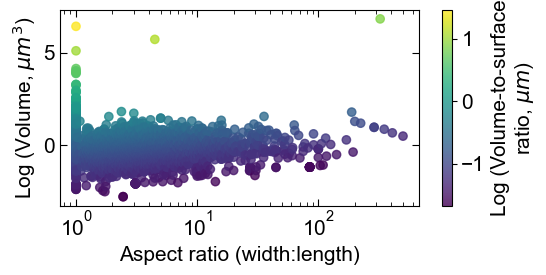

In [12]:
plt.figure(figsize = (6, 3))

plt.scatter(df['aspect_ratio'], df['log_volume_gmean'], alpha = 0.8, c = df['log_vsratio'])

plt.colorbar(label = 'Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xscale('log')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)
plt.xlabel('Aspect ratio (width:length)')
plt.ylabel(f'Log (Volume, $\\mu m^3$)')

plt.show()

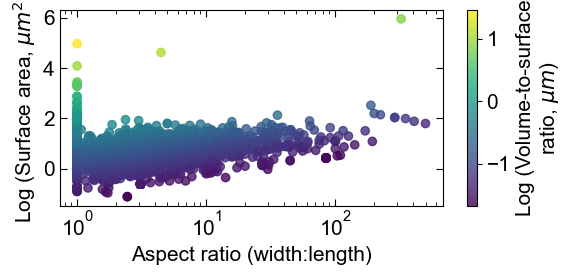

In [13]:
plt.figure(figsize = (6, 3))

plt.scatter(df['aspect_ratio'], df['log_surface_gmean'], alpha = 0.8, c = df['log_vsratio'])

plt.colorbar(label = 'Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xscale('log')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)
plt.xlabel('Aspect ratio (width:length)')
plt.ylabel(f'Log (Surface area, $\\mu m^2$)')

plt.show()

In [14]:
df_spheres = df[df['aspect_ratio'] == 1]

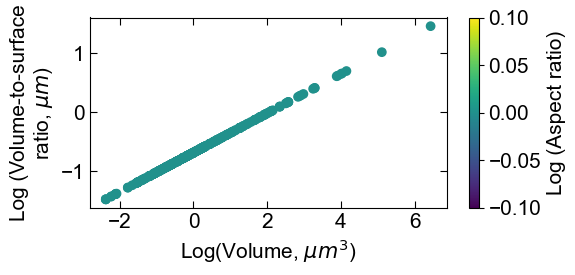

In [15]:
plt.figure(figsize = (6, 3))

plt.scatter(df_spheres['log_volume_gmean'], df_spheres['log_vsratio'], c = np.log10(df_spheres['aspect_ratio']))

plt.colorbar(label = 'Log (Aspect ratio)')
plt.ylabel('Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xlabel(f'Log(Volume, $\\mu m^3$)')

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)

plt.show()

In [16]:
df_rods = df[df['aspect_ratio'] > 1]

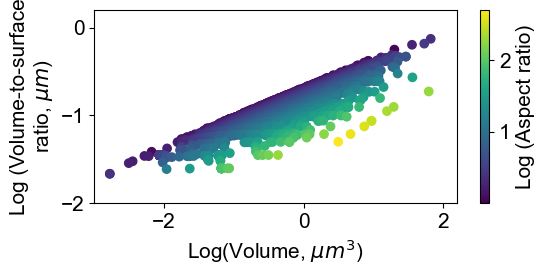

In [17]:
plt.figure(figsize = (6, 3))

plt.scatter(df_rods['log_volume_gmean'], df_rods['log_vsratio'], c = np.log10(df_rods['aspect_ratio']))
plt.colorbar(label = 'Log (Aspect ratio)')

plt.ylabel('Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xlabel(f'Log(Volume, $\\mu m^3$)')

# Exclue giant bacteria from the picture
plt.ylim(-2, 0.2)
plt.xlim(-3, 2.2)

plt.show()

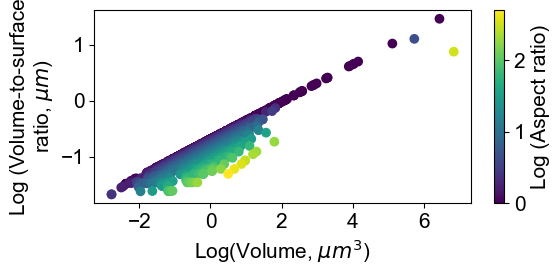

In [18]:
plt.figure(figsize = (6, 3))

plt.scatter(df['log_volume_gmean'], df['log_vsratio'], c = np.log10(df['aspect_ratio']))
plt.colorbar(label = 'Log (Aspect ratio)')

plt.ylabel('Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xlabel(f'Log(Volume, $\\mu m^3$)')

# Exclue giant bacteria from the picture
# plt.ylim(-2, 0.2)
# plt.xlim(-3, 2.2)

plt.show()

**Add shapes**

In [19]:
sh_keys = [['coccus', 'sphere', 'ovoid'], ['rod'], ['filament'], ['helical', 'spiral', 'vibrio']]
sh_labels = ['Cocci', 'Rods', 'Filaments', 'Spirals']
sh_colors = ['#ef767a', '#456990', '#49beaa', '#9d4edd']

In [20]:
xcol, ycol = 'log_volume_gmean', 'log_vsratio'
x, y = df[xcol], df[ycol]

Perform KDE

In [21]:
kernel = gaussian_kde(np.vstack([x, y]))

Bandwidth

In [22]:
bw = np.sqrt(np.sqrt(np.prod(np.diag(kernel.covariance))))

Plot range (200 x 200 grid, 3x bandwidth beyond extreme)

In [23]:
cut = 3
gridsize = 200

In [24]:
xmin = x.min() - bw * cut
xmax = x.max() + bw * cut

In [25]:
ymin = y.min() - bw * cut
ymax = y.max() + bw * cut

In [26]:
xran = np.linspace(xmin, xmax, gridsize)
yran = np.linspace(ymin, ymax, gridsize)

In [27]:
X, Y = np.meshgrid(xran, yran)

In [28]:
xygrid = np.vstack([X.ravel(), Y.ravel()])

KDE on each shape

In [29]:
sh_Zs = [gaussian_kde(df.query('shape == @k')[[xcol, ycol]].values.T)(
    xygrid).reshape(gridsize, gridsize) for k in sh_keys]

In [30]:
sh_dats = [df.query('shape == @k')['log_vsratio'].values for k in sh_keys]

Determine contour threshold by shape fraction.

In [31]:
n = df.shape[0]

In [32]:
sh_fracs = [d.size / n for d in sh_dats]

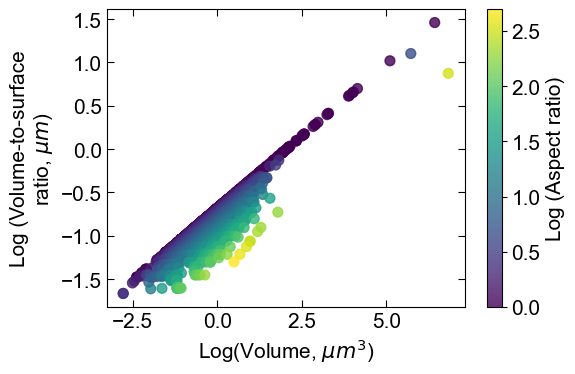

In [33]:
plt.figure(figsize = (6, 4))

plt.scatter(df['log_volume_gmean'], df['log_vsratio'], c = np.log10(df['aspect_ratio']),
           s = 50, cmap = 'viridis', alpha = 0.8)
plt.colorbar(label = 'Log (Aspect ratio)')

# for Z_, label, color, frac in zip(sh_Zs, sh_labels, sh_colors, sh_fracs):
#     print(label)
#     plt.contour(X, Y, Z_, levels = [0.001 / frac], colors = color, label = label)

# plt.legend(title = 'Shape')
plt.ylabel('Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xlabel(f'Log(Volume, $\\mu m^3$)')

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)
plt.savefig('figures/vsratio_volume_aspect_ratio.svg')
plt.show()

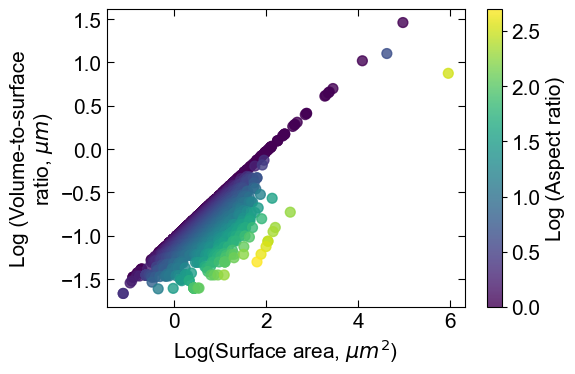

In [34]:
plt.figure(figsize = (6, 4))

plt.scatter(df['log_surface_gmean'], df['log_vsratio'], c = np.log10(df['aspect_ratio']),
           s = 50, cmap = 'viridis', alpha = 0.8)
plt.colorbar(label = 'Log (Aspect ratio)')

# for Z_, label, color, frac in zip(sh_Zs, sh_labels, sh_colors, sh_fracs):
#     print(label)
#     plt.contour(X, Y, Z_, levels = [0.001 / frac], colors = color, label = label)

# plt.legend(title = 'Shape')
plt.ylabel('Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xlabel(f'Log(Surface area, $\\mu m^2$)')

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)
plt.savefig('figures/vsratio_surface_aspect_ratio.svg')
plt.show()

**Clearly, several volumes will map to the same V/S ratio depending on the aspect ratio of the cell. Yet, V/S is an intuitive measure of linear cell size that is dependent on the aspect ratio of the cell. Because V and S have been calculated using the formulae for a capsule, any metric of cell size is forgiving enought that it approximates the size indepently of the cell shape.**

# Metric suggested by reviewer

Reduced volume from the 'Giant vesicle book'

$$
v = \frac{6 \sqrt{\pi} V}{S^{3/2}}
$$

which is unitless and dimensionless measure. $V$ = volume and $S$ = surface.

In [35]:
df['reduced_volume'] = (6 * np.sqrt(np.pi) * df['volume_gmean']) / (df['surface_gmean'] ** (3/2))
df['log_reduced_volume'] = np.log10(df['reduced_volume'])

In [36]:
xcol, ycol = 'log_volume_gmean', 'log_reduced_volume'
x, y = df[xcol], df[ycol]

Perform KDE

In [37]:
kernel = gaussian_kde(np.vstack([x, y]))

Bandwidth

In [38]:
bw = np.sqrt(np.sqrt(np.prod(np.diag(kernel.covariance))))

Plot range (200 x 200 grid, 3x bandwidth beyond extreme)

In [39]:
cut = 3
gridsize = 200

In [40]:
xmin = x.min() - bw * cut
xmax = x.max() + bw * cut

In [41]:
ymin = y.min() - bw * cut
ymax = y.max() + bw * cut

In [42]:
xran = np.linspace(xmin, xmax, gridsize)
yran = np.linspace(ymin, ymax, gridsize)

In [43]:
X, Y = np.meshgrid(xran, yran)

In [44]:
xygrid = np.vstack([X.ravel(), Y.ravel()])

KDE on each shape

In [45]:
sh_Zs = [gaussian_kde(df.query('shape == @k')[[xcol, ycol]].values.T)(
    xygrid).reshape(gridsize, gridsize) for k in sh_keys]

In [46]:
sh_dats = [df.query('shape == @k')['log_reduced_volume'].values for k in sh_keys]

Determine contour threshold by shape fraction.

In [47]:
n = df.shape[0]

In [48]:
sh_fracs = [d.size / n for d in sh_dats]

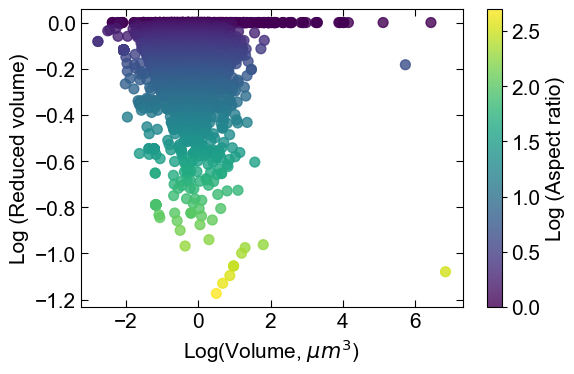

In [49]:
plt.figure(figsize = (6, 4))

plt.scatter(df['log_volume_gmean'], df['log_reduced_volume'], c = np.log10(df['aspect_ratio']),
           s = 50, cmap = 'viridis', alpha = 0.8)
plt.colorbar(label = 'Log (Aspect ratio)')

# for Z_, label, color, frac in zip(sh_Zs, sh_labels, sh_colors, sh_fracs):
#     plt.contour(X, Y, Z_, levels = [0.001 / frac], colors = color)
    
plt.ylabel('Log (Reduced volume)')
plt.xlabel(f'Log(Volume, $\\mu m^3$)')

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)

plt.savefig('figures/reduced_volume_volume_aspect_ratio.svg')
plt.show()

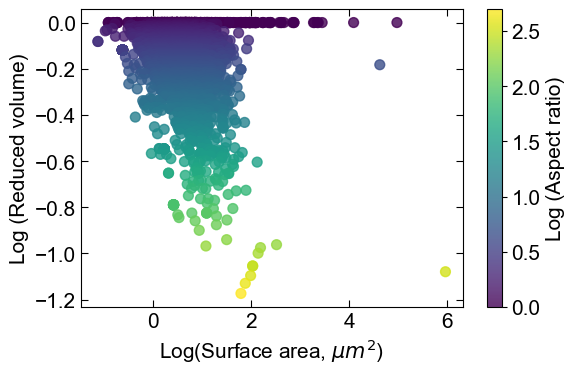

In [50]:
plt.figure(figsize = (6, 4))

plt.scatter(df['log_surface_gmean'], df['log_reduced_volume'], c = np.log10(df['aspect_ratio']),
           s = 50, cmap = 'viridis', alpha = 0.8)
plt.colorbar(label = 'Log (Aspect ratio)')

# for Z_, label, color, frac in zip(sh_Zs, sh_labels, sh_colors, sh_fracs):
#     plt.contour(X, Y, Z_, levels = [0.001 / frac], colors = color)
    
plt.ylabel('Log (Reduced volume)')
plt.xlabel(f'Log(Surface area, $\\mu m^2$)')

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)

plt.savefig('figures/reduced_volume_surface_aspect_ratio.svg')
plt.show()

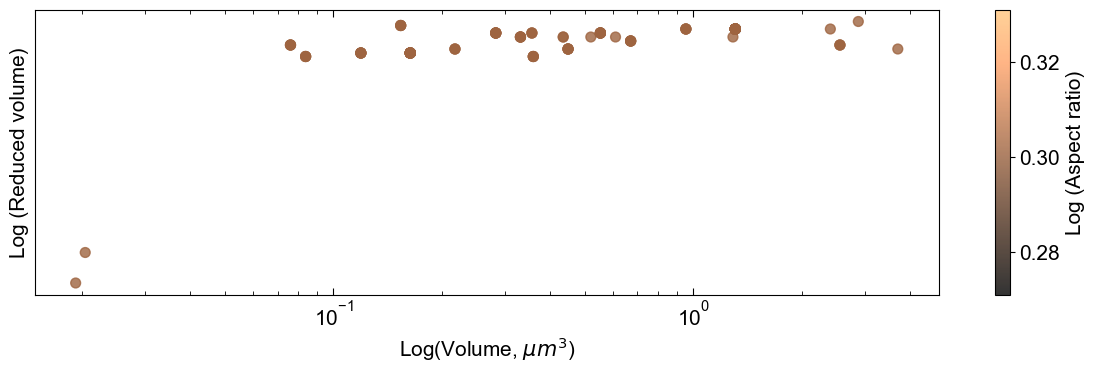

In [51]:
plt.figure(figsize = (12, 4))

datum = df[df['aspect_ratio'] == 2]
plt.scatter(datum['volume_gmean'], datum['reduced_volume'], c = np.log10(datum['aspect_ratio']),
           s = 50, cmap = 'copper', alpha = 0.8)
plt.colorbar(label = 'Log (Aspect ratio)')

# for Z_, label, color, frac in zip(sh_Zs, sh_labels, sh_colors, sh_fracs):
#     plt.contour(X, Y, Z_, levels = [0.001 / frac], colors = color)
    
plt.ylabel('Log (Reduced volume)')
plt.xlabel(f'Log(Volume, $\\mu m^3$)')
plt.xscale('log')
plt.yscale('log')

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)

# plt.savefig('figures/reduced_volume_aspect_ratio.svg')
plt.show()

# Another metric of linear size

[Equivalent spherical diameter](https://en.wikipedia.org/wiki/Equivalent_spherical_diameter).


The equivalent spherical diameter of a cell is the diameter of a sphere with equivalent volume (see Figure 1.3 from this [pdf](https://zenodo.org/records/6484683)).

**Derivation:** The volume of s sphere is $V_s = \frac{4}{3} \pi r^3$ and $d = 2r$. Then,

$$
V_s = \frac{4}{3} \pi \left(\frac{d}{2}\right)^3 = \frac{4}{3} \pi \frac{d^3}{8} = \frac{1}{6} \pi d^3
$$

$$
d_V = \sqrt[3]{\frac{6V}{\pi}}
$$

where $V$ is the volume of the cell, previously calculated using the formulae for a [capsule](https://en.wikipedia.org/wiki/Capsule_(geometry)).

In [53]:
df['equivalent_spherical'] = np.cbrt((6 * df['volume_gmean']) / np.pi)
df['log_equivalent_spherical'] = np.log10(df['equivalent_spherical'])

Calculate volume and surface area from a sphere

$$
V = \frac{\pi}{6} d^3
$$

$$
A = \pi d^2 
$$

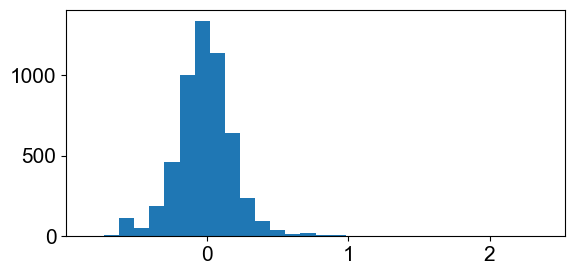

In [54]:
plt.figure(figsize = (6, 3))
plt.hist(df['log_equivalent_spherical'], bins = 30)
plt.show()

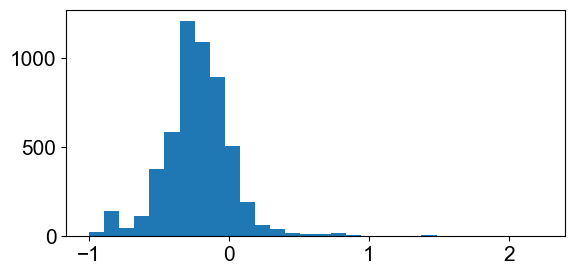

In [55]:
plt.figure(figsize = (6, 3))
plt.hist(df['log_width_gmean'], bins = 30)
plt.show()

In [56]:
df['volume_sphere'] = (np.pi / 6) * (df['equivalent_spherical'] ** 3)
df['surface_sphere'] = np.pi * (df['equivalent_spherical'] ** 2)

In [57]:
df['log_volume_sphere'] = np.log10(df['volume_sphere'])
df['log_surface_sphere'] = np.log10(df['surface_sphere'])

In [58]:
df['vsratio_sphere'] = df['volume_sphere'] / df['surface_sphere']
df['log_vsratio_sphere'] = np.log10(df['vsratio_sphere'])

In [59]:
xcol, ycol = 'log_volume_sphere', 'log_vsratio_sphere'
x, y = df[xcol], df[ycol]

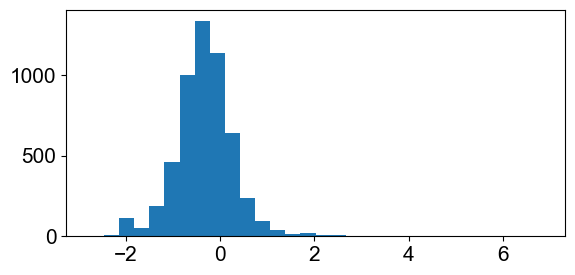

In [60]:
plt.figure(figsize = (6, 3))
plt.hist(df['log_volume_sphere'], bins = 30)
plt.show()

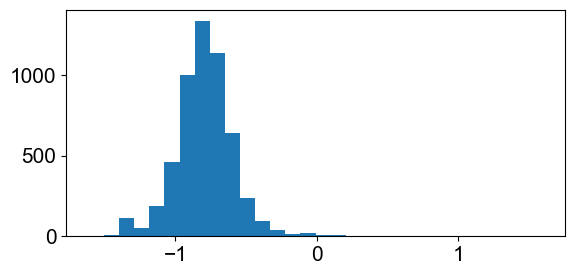

In [61]:
plt.figure(figsize = (6, 3))
plt.hist(df['log_vsratio_sphere'], bins = 30)
plt.show()

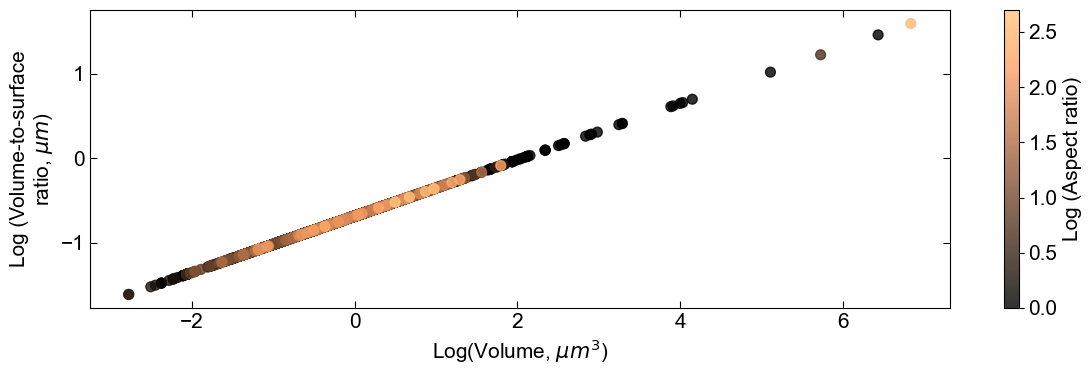

In [62]:
plt.figure(figsize = (12, 4))

plt.scatter(df['log_volume_sphere'], df['log_vsratio_sphere'], c = np.log10(df['aspect_ratio']),
           s = 50, cmap = 'copper', alpha = 0.8)
plt.colorbar(label = 'Log (Aspect ratio)')

# for Z_, label, color, frac in zip(sh_Zs, sh_labels, sh_colors, sh_fracs):
#     plt.contour(X, Y, Z_, levels = [0.001 / frac], colors = color)
    
plt.ylabel('Log (Volume-to-surface\nratio, $\\mu m$)')
plt.xlabel(f'Log(Volume, $\\mu m^3$)')

plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'minor', length = 3)

# plt.xlim(-1.5, -1.25)
# plt.ylim(-0.1, 1.5)
plt.show()